In [1]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from plotnine import *
from plotnine.data import *
from plotnine.data import economics
from plotnine import ggplot, aes, geom_line
from plotnine.geoms.geom_boxplot import geom_boxplot
from plotnine.geoms.geom_point import geom_point
from plotnine.geoms.geom_rug import coord_flip
from plotnine.labels import labs

from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, f1_score, accuracy_score, recall_score, precision_score, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from scipy.stats import randint as sp_randint
import warnings

In [ ]:
# Check if file already exists
matches = [match for match in os.listdir() if "messidor_features.arff" in match]

# If file is missing, then download it
if not matches:
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

# Data Cleaning

In [ ]:
# Load the data and convert to dataframe.
from scipy.io import arff
data = arff.loadarff('/content/messidor_features.arff')
df = pd.DataFrame(data[0])

In [ ]:
# 'q'           'ps'         'nma.a'           'nma.b'           'nma.c'           'nma.d'
# 'qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',

# 'nma.e'           'nma.f'            'nex.a'               'nex.b'                 'nex.c'                'nex.d'
# 'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'

#  'nex.e'                'nex.f'                'nex.g'                'nex.h'
# 'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',

# 'dd'        'dm'           'amfm'  'class_label
# 'euc_dist','diam_opt_disc','AM/FM','class_label'



In [ ]:
col_names = ['q', 'ps', 'nma.a', 'nma.b', 'nma.c', 'nma.d', 'nma.e', 'nma.f', 
             'nex.a', 'nex.b', 'nex.c', 'nex.d', 'nex.e', 'nex.f', 'nex.g', 
             'nex.h', 'dd', 'dm', 'amfm', 'class_label']

df.columns = col_names

In [ ]:
# Extract binary class in numeric form (1 or 0) from string.
df.class_label = df.class_label.apply(lambda x: pd.to_numeric(str(x)[2]))

In [ ]:
# Center the data while scaling a vector. 
# When comparing vectors, it reduces the effect of a different scale, 
# bringing it closer to a normal distribution.
df.iloc[:, 2:17] = scale(df.iloc[:, 2:17])

# Ensure that the value in class_label is numeric
df["class_label"], _ = pd.factorize(df["class_label"], sort=True)

In [ ]:
# Unpivots a DataFrame from wide format to long format
long = pd.melt(df.iloc[:, 0:len(df.columns)-1], col_level=0)

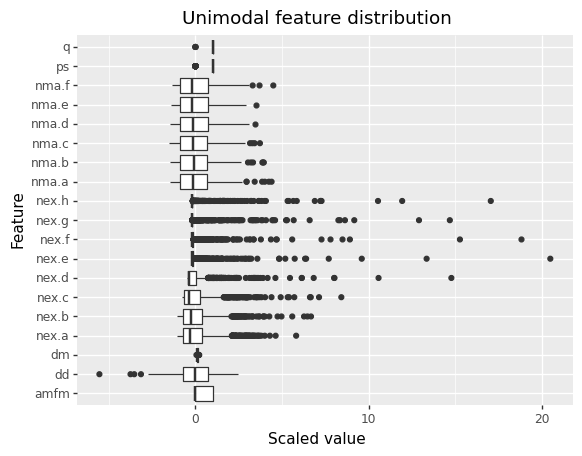

<ggplot: (8781133293728)>

In [ ]:
# ggplot - package used for data visualizations
# geom_boxplot - creates boxplot graph
# coord_flip - flips graph horizontal
# labs - changes the title and labels
ggplot(long) + geom_boxplot(aes(x='variable', y='value')) + coord_flip() + labs(title="Unimodal feature distribution", x='Feature', y='Scaled value')

In [ ]:
# Pairwise correlation of columns,
df.corr().style.background_gradient(cmap='PuBu')

In [ ]:
# ggplot - package used for data visualizations
# geom_point - creates scatter plot
# aes - aesthetic mappings
# facet_wrap - produce plots for the combinations of variables that have values
ggplot(df) + geom_point(aes(x="nma.a", y="nma.b", color="class_label")) + facet_wrap("~amfm")

In [ ]:
# ggplot - package used for data visualizations
# geom_point - creates scatter plot
# aes - aesthetic mappings
# facet_wrap - produce plots for the combinations of variables that have values
ggplot(df) + geom_point(aes(x="nma.a", y="nma.f", color="class_label")) + facet_wrap("~amfm")

In [ ]:
# ggplot - package used for data visualizations
# geom_point - creates scatter plot
# aes - aesthetic mappings
# facet_wrap - produce plots for the combinations of variables that have values
ggplot(df) + geom_point(aes(x="nex.a", y="nex.b", color="class_label")) + facet_wrap("~amfm")

In [ ]:
# ggplot - package used for data visualizations
# geom_point - creates scatter plot
# aes - aesthetic mappings
# facet_wrap - produce plots for the combinations of variables that have values
ggplot(df) + geom_point(aes(x="nex.a", y="nex.h", color="class_label")) + facet_wrap("~amfm")

In [ ]:
# ggplot - package used for data visualizations
# geom_point - creates scatter plot
# aes - aesthetic mappings
# facet_wrap - produce plots for the combinations of variables that have values
ggplot(df) + geom_point(aes(x="nma.a", y="nex.h", color="class_label")) + facet_wrap("~amfm")

In [ ]:
# Since we will need to drop all but 1 of the MA features, we will try 6 different datasets, each keeping a
# different MA feature. Initialize these data frames by backing copy of original.

df_MA5 = df.copy()
df_MA6 = df.copy()
df_MA7 = df.copy()
df_MA8 = df.copy()
df_MA9 = df.copy()
df_MA10 = df.copy()

In [ ]:
# For each new dataframe, specify the MA columns we want to drop (all but 1). Also drop every other exudate
# detection column for all datasets. This will eliminate correlation among exudate features.

# 'q'           'ps'         'nma.a'  'nma.b'  'nma.c'  'nma.d'
# 'qual_assess','pre_screen','MAD_.5','MAD_.6','MAD_.7','MAD_.8',

# 'nma.e'  'nma.f'   'nex.a'  'nex.b'  'nex.c'  'nex.d'
# 'MAD_.9','MAD_1.0','exD_.3','exD_.4','exD_.5','exD_.6'

# 'nex.e'  'nex.f'  'nex.g'  'nex.h'
# 'exD_.7','exD_.8','exD_.9','exD_1.0',

# 'dd'        'dm'           'amfm'  'class_label
# 'euc_dist','diam_opt_disc','AM/FM','class_label'

#drop_5 = ['MAD_1.0','MAD_.6','MAD_.7','MAD_.8','MAD_.9', 'exD_.4','exD_.6','exD_.8','exD_1.0']
#drop_6 = ['MAD_.5','MAD_1.0','MAD_.7','MAD_.8','MAD_.9', 'exD_.4','exD_.6','exD_.8','exD_1.0']
#drop_7 = ['MAD_.5','MAD_.6','MAD_1.0','MAD_.8','MAD_.9', 'exD_.4','exD_.6','exD_.8','exD_1.0']
#drop_8 = ['MAD_.5','MAD_.6','MAD_.7','MAD_1.0','MAD_.9', 'exD_.4','exD_.6','exD_.8','exD_1.0']
#drop_9 = ['MAD_.5','MAD_.6','MAD_.7','MAD_.8','MAD_1.0', 'exD_.4','exD_.6','exD_.8','exD_1.0']
#drop_10 = ['MAD_.5','MAD_.6','MAD_.7','MAD_.8','MAD_.9', 'exD_.4','exD_.6','exD_.8','exD_1.0']

drop_5 = ['nma.f','nma.b','nma.c','nma.d','nma.e', 'nex.b','nex.d','nex.f','nex.h']
drop_6 = ['nma.a','nma.f','nma.c','nma.d','nma.e', 'nex.b','nex.d','nex.f','nex.h']
drop_7 = ['nma.a','nma.b','nma.f','nma.d','nma.e', 'nex.b','nex.d','nex.f','nex.h']
drop_8 = ['nma.a','nma.b','nma.c','nma.f','nma.e', 'nex.b','nex.d','nex.f','nex.h']
drop_9 = ['nma.a','nma.b','nma.c','nma.d','nma.f', 'nex.b','nex.d','nex.f','nex.h']
drop_10 = ['nma.a','nma.b','nma.c','nma.d','nma.e', 'nex.b','nex.d','nex.f','nex.h']


In [ ]:
# Drop appropriate columns to create these dataframes.

df_MA5.drop(columns = drop_5, inplace = True)
df_MA6.drop(columns = drop_6, inplace = True)
df_MA7.drop(columns = drop_7, inplace = True)
df_MA8.drop(columns = drop_8, inplace = True)
df_MA9.drop(columns = drop_9, inplace = True)
df_MA10.drop(columns = drop_10, inplace = True)

In [ ]:
# Check to make sure the desired result is achieved. 

print(df_MA5.columns)
print(df_MA6.columns)
print(df_MA7.columns)
print(df_MA8.columns)
print(df_MA9.columns)
print(df_MA10.columns)

In [ ]:
# Check the correlation of each dataframe. 

fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA5.corr()) > .8)

In [ ]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA6.corr()) > .8)

In [ ]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA7.corr()) > .8)

In [ ]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA8.corr()) > .8)

In [ ]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA9.corr()) > .8)

In [ ]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA10.corr()) > .8)

In [ ]:
# Divide each new dataframe between variables and target. 

X = df.iloc[:,0:-1]
y = df.class_label

X_MA5 = df_MA5.iloc[:,0:-1]
y_MA5 = df_MA5.class_label

X_MA6 = df_MA6.iloc[:,0:-1]
y_MA6 = df_MA6.class_label

X_MA7 = df_MA7.iloc[:,0:-1]
y_MA7 = df_MA7.class_label

X_MA8 = df_MA8.iloc[:,0:-1]
y_MA8 = df_MA8.class_label

X_MA9 = df_MA9.iloc[:,0:-1]
y_MA9 = df_MA9.class_label

X_MA10 = df_MA10.iloc[:,0:-1]
y_MA10 = df_MA10.class_label

In [ ]:
# Perform a test-train split for each dataframe.

X_train_MA5, X_test_MA5, y_train_MA5, y_test_MA5     = train_test_split(X_MA5,y_MA5,test_size=.2,random_state=27,stratify=y_MA5)
X_train_MA6, X_test_MA6, y_train_MA6, y_test_MA6     = train_test_split(X_MA6,y_MA6,test_size=.2,random_state=27,stratify=y_MA6)
X_train_MA7, X_test_MA7, y_train_MA7, y_test_MA7     = train_test_split(X_MA7,y_MA7,test_size=.2,random_state=27,stratify=y_MA7)
X_train_MA8, X_test_MA8, y_train_MA8, y_test_MA8     = train_test_split(X_MA8,y_MA8,test_size=.2,random_state=27,stratify=y_MA8)
X_train_MA9, X_test_MA9, y_train_MA9, y_test_MA9     = train_test_split(X_MA9,y_MA9,test_size=.2,random_state=27,stratify=y_MA9)
X_train_MA10, X_test_MA10, y_train_MA10, y_test_MA10 = train_test_split(X_MA10,y_MA10,test_size=.2,random_state=27,stratify=y_MA10)

In [ ]:
# Create a baseline classifier 

dummy = DummyClassifier(strategy='most_frequent', random_state=13).fit(X, y)
dummy_predict = dummy.predict(X)

print('Test Accuracy score: ', accuracy_score(y, dummy_predict))
print('Test F1 score: ', f1_score(y, dummy_predict))

Test Accuracy score:  0.5308427454387489
Test F1 score:  0.6935300794551646


In [ ]:
baseline_accuracy = accuracy_score(y, dummy_predict)

In [ ]:
# Create dictionaries containing all train sets and all test sets respectively. 

train_sets = {'MA=.5_train':(X_train_MA5,y_train_MA5),
              'MA=.6_train':(X_train_MA6,y_train_MA6),
              'MA=.7_train':(X_train_MA7,y_train_MA7),
              'MA=.8_train':(X_train_MA8,y_train_MA8),
              'MA=.9_train':(X_train_MA9,y_train_MA9),
              'MA=1.0_train':(X_train_MA10,y_train_MA10)}

test_sets = {'MA=.5_test':(X_test_MA5,y_test_MA5),
             'MA=.6_test':(X_test_MA6,y_test_MA6),
             'MA=.7_test':(X_test_MA7,y_test_MA7),
             'MA=.8_test':(X_test_MA8,y_test_MA8),
             'MA=.9_test':(X_test_MA9,y_test_MA9),
             'MA=1.0_test':(X_test_MA10,y_test_MA10)}

In [ ]:
# Create a column transformer object to incorporate into pipeline. This object will scale numerical values and leave
# categorical encoded variables untouched. 
preprocess_dict = {}
for key, val in train_sets.items():
    numerical = list(val[0].iloc[:,2:9].columns)
    preprocess_dict[key+'_scaled'] = make_column_transformer((StandardScaler(),numerical),
                                                            remainder = 'passthrough')

In [ ]:
# For each dataframe, each keeping a different MA detection feature, perform a Logistic Regression pipeline.
# Pipeline scales numerical features, performs a PCA and Logistic Regression. A Grid Search with 5-fold 
# cross validation takes the in the pipeline object to optimize the classifer trying various hyperparameters
# and PCA components. Optimal model, best parameters, and best accuracy will be added to a dictionary. 

LR_best_scores = {}
for key, val in train_sets.items():
    preprocess = preprocess_dict[key+'_scaled']
    model = make_pipeline(preprocess, PCA(),LogisticRegression(solver = 'liblinear'))
    params = {
              'pca__n_components': [5,6,7,8,9,None], 
              'logisticregression__penalty':['l1','l2'],
              'logisticregression__C':[100,10,1,.1,.01,.001],
              'logisticregression__fit_intercept':[False,True]
             }

    search_lr = GridSearchCV(estimator = model, param_grid = params,
                     cv = 5, return_train_score = True,
                      n_jobs = -1)

    search_lr.fit(val[0], val[1])
    LR_best_scores[key] = {'model':search_lr, 'best_params':search_lr.best_params_,
                           'best_score':search_lr.best_score_}

In [ ]:
# See which dataframe varying by MA detection feature had the best score. 

for key in train_sets.keys():
    print(key, ': ',LR_best_scores[key]['best_score'])

MA=.5_train :  0.6619565217391304
MA=.6_train :  0.6543478260869565
MA=.7_train :  0.6467391304347826
MA=.8_train :  0.6402173913043478
MA=.9_train :  0.6445652173913043
MA=1.0_train :  0.625


In [ ]:
LR_best_scores['MA=.5_train']['best_params']

{'logisticregression__C': 1,
 'logisticregression__fit_intercept': False,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 7}

In [ ]:
# Generate classifier metrics for this optimal classifier. 

y_hat_test_MA5_LR = LR_best_scores['MA=.5_train']['model'].predict(X_test_MA5)
print('Logistic Regression')
print('Accuracy Score: ', accuracy_score(y_test_MA5,y_hat_test_MA5_LR))
print('Precision Score: ', precision_score(y_test_MA5,y_hat_test_MA5_LR))
print('Recall Score: ', recall_score(y_test_MA5,y_hat_test_MA5_LR))
print('F1 Score: ',f1_score(y_test_MA5,y_hat_test_MA5_LR))

Logistic Regression
Accuracy Score:  0.6623376623376623
Precision Score:  0.8461538461538461
Recall Score:  0.44715447154471544
F1 Score:  0.5851063829787234


In [ ]:
# Prepare model for ROC curve. 
y_score_LR = LR_best_scores['MA=.5_train']['model'].decision_function(X_test_MA5)
fpr_LR, tpr_LR, thresholds = roc_curve(y_test_MA5, y_score_LR)

AUC: 0.6965522433002108


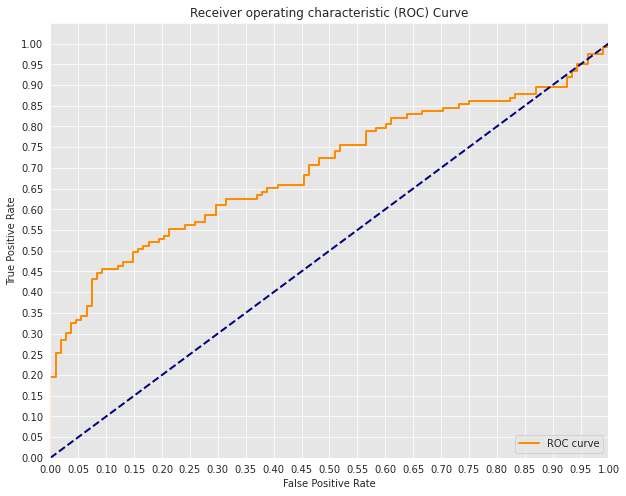

In [ ]:
# Generate ROC curve. 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr_LR, tpr_LR)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr_LR, tpr_LR, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()